In [1]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
%matplotlib inline

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import KFold
import os
print(os.listdir("../input"))
#path="E:\surya\work\kaggle titanic dataset"
#os.chdir(path)
# Any results you write to the current directory are saved as output.

['test.csv', 'train.csv', 'gender_submission.csv']


In [2]:
print (os.listdir(os.getcwd()))

['__notebook_source__.ipynb', '.ipynb_checkpoints']


In [3]:
#Step 1: Dataset Exploration

In [4]:
print ("\ntotal number of datapoints : 891")
print ("\nnumber of useful features available : 9")
print ("\nname of the passenger is not used as a feature.")
print ("\ncabin number has many missing values")


total number of datapoints : 891

number of useful features available : 9

name of the passenger is not used as a feature.

cabin number has many missing values


In [5]:
#reading training dataset
feature_list=['PassengerId','Pclass','Name','Sex', 'Age','SibSp','Parch',
                                                   'Ticket','Fare','Cabin','Embarked']
df_train_features=pd.read_csv("../input/train.csv",usecols=feature_list)
df_train_labels=pd.read_csv("../input/train.csv",usecols=['Survived'])

df_test_features=pd.read_csv("../input/test.csv",usecols=feature_list)

In [6]:
df_train_features.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
df_train_labels.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [8]:
df_test_features.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [9]:
#DATA PRE-PROCESSING

#replacing 'male' with 1 and 'female' with 0 in the 'sex' column
df_train_features=df_train_features.replace('male',1)
df_train_features=df_train_features.replace('female',0)

df_test_features=df_test_features.replace('male',1)
df_test_features=df_test_features.replace('female',0)

#extracting the numerical part of the ticket number
#c=5
for s in df_train_features.iloc[:,7]:
    if isinstance(s,str):
        value=[int(s) for s in s.split(' ') if s.isdigit()]
        if (len(value)!=0):
            tktnum=value[0]
        else:
            tktnum=-1
        #if (c>0):
          #  c-=1
        df_train_features=df_train_features.replace(s,tktnum)
        #df_test_features=df_test_features.replace(s,tktnum)
        
#c=5
for s in df_test_features.iloc[:,7]:
    if isinstance(s,str):
        value=[int(s) for s in s.split(' ') if s.isdigit()]
        if (len(value)!=0):
            tktnum=value[0]
        else:
            tktnum=-1
        #if (c>0):
           # c-=1
        #df_train_features=df_train_features.replace(s,tktnum)
        df_test_features=df_test_features.replace(s,tktnum)

#In 'embarked' column, replacing 'S' by 1,'C' by 2 and 'Q' by 3
df_train_features['Embarked'] = df_train_features['Embarked'].replace({"S":1.0,"C":2.0,"Q":3.0})
df_test_features['Embarked'] = df_test_features['Embarked'].replace({"S":1.0,"C":2.0,"Q":3.0})

#Extracting only the surnames
for s in df_train_features.iloc[:,2]:
    if (len(s)!=0):
        value=[s for s in s.split(',')]
        surname=value[0]
    df_train_features=df_train_features.replace(s,surname)
    df_test_features=df_test_features.replace(s,surname)

#finding the list of unique surnames present and assigning them a numerical value
ls=df_train_features.Name.unique()
df_train_features=df_train_features.replace(ls,range(len(ls)))
ls=df_test_features.Name.unique()
df_test_features=df_test_features.replace(ls,range(len(ls)))

#For cases where a passenger has more than one cabin number, extra features will be added. 
#If a person has two cabins, then 4 features will be added. 2 for alpha. part and 2 for numerical part.    
#splitting cabin number in two parts: cabin1 : contains the alphabetical part and cabin2 : contains the numerical part

#first let us find the maximum number of cabins a passenger has.
Max=0
for s in df_train_features.iloc[:,9]:
    if isinstance(s,str):
        value=[s for s in s.split(' ')]
        if (Max<len(value)):
            Max=len(value)
print ('maximum number of cabins a passenger has : ',Max)

#now let us add the required number of features with default values for each row. Later on the value of a row will be changed as 
#'needed'
x=range(Max)
for i in x:
    df_train_features.loc[:,'ap'+str(i)]=-1
    df_train_features.loc[:,'np'+str(i)]=-1
    df_test_features.loc[:,'ap'+str(i)]=-1
    df_test_features.loc[:,'np'+str(i)]=-1
    feature_list.append('ap'+str(i))
    feature_list.append('np'+str(i))
#now let us fill in the apprpriate values in these new columns
ap=11
np=12
rowin=0

for s in df_train_features.iloc[:,9]:
    if isinstance(s,str):
        #print (s)
        #print (type(s))
        value=[s for s in s.split(' ')]
        for cn in value:
            #print (cn[0])
            #print (cn[1:])
            #print (ap)
            df_train_features.iloc[rowin,ap]=ord(cn[0])
            #df_test_features.iloc[rowin,ap]=ord(cn[0])
            if (cn[1:]!=''):
                df_train_features.iloc[rowin,np]=int(cn[1:])
                #df_test_features.iloc[rowin,np]=int(cn[1:])
            else:
                df_train_features.iloc[rowin,np]=-1
                #df_test_features.iloc[rowin,np]=-1
            ap+=2
            np+=2
    ap=11
    np=12
    rowin+=1

ap=11
np=12
rowin=0
    
for s in df_test_features.iloc[:,9]:
    if isinstance(s,str):
        #print (s)
        #print (type(s))
        value=[s for s in s.split(' ')]
        for cn in value:
            #print (cn[0])
            #print (cn[1:])
            #print (ap)
            #df_train_features.iloc[rowin,ap]=ord(cn[0])
            df_test_features.iloc[rowin,ap]=ord(cn[0])
            if (cn[1:]!=''):
                #df_train_features.iloc[rowin,np]=int(cn[1:])
                df_test_features.iloc[rowin,np]=int(cn[1:])
            else:
                #df_train_features.iloc[rowin,np]=-1
                df_test_features.iloc[rowin,np]=-1
            ap+=2
            np+=2
    ap=11
    np=12
    rowin+=1
    
            
#finally removing the original 'cabin' column
df_train_features=df_train_features.drop(columns=['Cabin'])
df_test_features=df_test_features.drop(columns=['Cabin'])
#removing from features list as well
del feature_list[feature_list.index('Cabin')]

#replacing all the missing values in age column by mean age
mean_age=df_train_features['Age'].mean()
df_train_features['Age']=df_train_features['Age'].fillna(mean_age)
df_test_features['Age']=df_test_features['Age'].fillna(mean_age)

#there are two nan values present in 'Embarked' column. we are replacing it with median value
median=df_train_features['Embarked'].median()
df_train_features['Embarked']=df_train_features['Embarked'].fillna(median)
df_test_features['Embarked']=df_test_features['Embarked'].fillna(median)


#checking for any NAN values left
l=[]
for i in feature_list:
    x=df_test_features[i].isnull().sum().sum()
    if x>0:
        print (x)
        l.append(i)
for i in l:
    print (i)

maximum number of cabins a passenger has :  4
1
Fare


In [10]:
avg_fare=df_test_features['Fare'].mean()
df_test_features['Fare']=df_test_features['Fare'].fillna(avg_fare)

In [11]:
df_train_features.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,ap0,np0,ap1,np1,ap2,np2,ap3,np3
0,1,3,0,1,22.0,1,0,21171,7.2500,1.0,-1,-1,-1,-1,-1,-1,-1,-1
1,2,1,1,0,38.0,1,0,17599,71.2833,2.0,67,85,-1,-1,-1,-1,-1,-1
2,3,3,2,0,26.0,0,0,3101282,7.9250,1.0,-1,-1,-1,-1,-1,-1,-1,-1
3,4,1,3,0,35.0,1,0,113803,53.1000,1.0,67,123,-1,-1,-1,-1,-1,-1
4,5,3,4,1,35.0,0,0,373450,8.0500,1.0,-1,-1,-1,-1,-1,-1,-1,-1


In [12]:
df_test_features.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,ap0,np0,ap1,np1,ap2,np2,ap3,np3
0,892,3,0,1,34.5,0,0,330911,7.8292,3.0,-1,-1,-1,-1,-1,-1,-1,-1
1,893,3,1,0,47.0,1,0,363272,7.0000,1.0,-1,-1,-1,-1,-1,-1,-1,-1
2,894,2,2,1,62.0,0,0,240276,9.6875,3.0,-1,-1,-1,-1,-1,-1,-1,-1
3,895,3,3,1,27.0,0,0,315154,8.6625,1.0,-1,-1,-1,-1,-1,-1,-1,-1
4,896,3,4,0,22.0,1,1,3101298,12.2875,1.0,-1,-1,-1,-1,-1,-1,-1,-1


In [13]:
#Converting dataframe to numpy arrays for further use
X=df_train_features.values
y=df_train_labels.values
X_test=df_test_features.values

print ('X.shape = %s' % str(X.shape))
print ('y.shape = %s' % str(y.shape))
print ('X_test.shape = %s' % str(X_test.shape))

X.shape = (891, 18)
y.shape = (891, 1)
X_test.shape = (418, 18)


In [14]:
X

array([[  1.,   3.,   0., ...,  -1.,  -1.,  -1.],
       [  2.,   1.,   1., ...,  -1.,  -1.,  -1.],
       [  3.,   3.,   2., ...,  -1.,  -1.,  -1.],
       ...,
       [889.,   3., 604., ...,  -1.,  -1.,  -1.],
       [890.,   1., 665., ...,  -1.,  -1.,  -1.],
       [891.,   3., 666., ...,  -1.,  -1.,  -1.]])

In [15]:
X_test

array([[ 8.920e+02,  3.000e+00,  0.000e+00, ..., -1.000e+00, -1.000e+00,
        -1.000e+00],
       [ 8.930e+02,  3.000e+00,  1.000e+00, ..., -1.000e+00, -1.000e+00,
        -1.000e+00],
       [ 8.940e+02,  2.000e+00,  2.000e+00, ..., -1.000e+00, -1.000e+00,
        -1.000e+00],
       ...,
       [ 1.307e+03,  3.000e+00,  4.150e+02, ..., -1.000e+00, -1.000e+00,
        -1.000e+00],
       [ 1.308e+03,  3.000e+00,  4.160e+02, ..., -1.000e+00, -1.000e+00,
        -1.000e+00],
       [ 1.309e+03,  3.000e+00,  4.170e+02, ..., -1.000e+00, -1.000e+00,
        -1.000e+00]])

In [16]:
#Step 2: OPTIMIZE FEATURE SELECTION/ENGINEERING

In [17]:
#First, let us do feature scalling so that no feature gets more importance simply based on it's numerical value
#feature scalling
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X=scaler.fit_transform(X)


#scaler=MinMaxScaler()
X_test=scaler.fit_transform(X_test)



In [18]:
X[0:5]

array([[0.        , 1.        , 0.        , 1.        , 0.27117366,
        0.125     , 0.        , 0.00682677, 0.01415106, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.0011236 , 0.        , 0.0015015 , 0.        , 0.4722292 ,
        0.125     , 0.        , 0.00567501, 0.13913574, 0.5       ,
        0.8       , 0.57718121, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.00224719, 1.        , 0.003003  , 0.        , 0.32143755,
        0.        , 0.        , 0.99998871, 0.01546857, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.00337079, 0.        , 0.0045045 , 0.        , 0.43453129,
        0.125     , 0.        , 0.03669537, 0.1036443 , 0.        ,
        0.8       , 0.83221477, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
    

In [19]:
X_test[0:5]

array([[0.        , 1.        , 0.        , 1.        , 0.4527232 ,
        0.        , 0.        , 0.10669965, 0.01528158, 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.00239808, 1.        , 0.00239808, 0.        , 0.61756561,
        0.125     , 0.        , 0.11713426, 0.01366309, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.00479616, 0.5       , 0.00479616, 1.        , 0.8153765 ,
        0.        , 0.        , 0.07747493, 0.01890874, 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.00719424, 1.        , 0.00719424, 1.        , 0.35381775,
        0.        , 0.        , 0.10161889, 0.01690807, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
    

In [20]:
print (y[:5])

[[0]
 [1]
 [1]
 [1]
 [0]]


In [21]:
len(y)

891

In [22]:
new=[]
for i in y:
    for j in i:
        new.append(j)
print (new[:5])
y=new

[0, 1, 1, 1, 0]


In [23]:
#now let us find the importance of all features using selectkpercentile
from sklearn.feature_selection import SelectPercentile, f_classif
selector = SelectPercentile(f_classif, percentile=80)#highest accuracy .80 (approx.) from decision tree classifier
#                                                                                                   at this percentile
selector.fit(X,y)
X_new=selector.transform(X)
print ('shape of X_new ',X_new.shape)
try:
    X_points = range(X.shape[1])
except IndexError:
    X_points = 1
    

#using previously selected features
X_test=selector.transform(X_test)
print ('X_test.shape = %s ' % str(X_test.shape))
'''
try:
    X_points = range(X_test.shape[1])
except IndexError:
    X_points = 1
'''    

shape of X_new  (891, 14)
X_test.shape = (418, 14) 


'\ntry:\n    X_points = range(X_test.shape[1])\nexcept IndexError:\n    X_points = 1\n'

In [24]:
#checking out the scores of the features
score=selector.scores_.tolist()
names=list(df_train_features)
new=zip(names,score)
for i in new:
    print (i[0]," score = {:8.2f}".format(i[1]))

PassengerId  score =     0.02
Pclass  score =   115.03
Name  score =     0.27
Sex  score =   372.41
Age  score =     4.35
SibSp  score =     1.11
Parch  score =     5.96
Ticket  score =     8.20
Fare  score =    63.03
Embarked  score =    10.26
ap0  score =    98.85
np0  score =    53.15
ap1  score =     3.97
np1  score =     4.91
ap2  score =     1.97
np2  score =     2.67
ap3  score =     3.22
np3  score =     3.22


<BarContainer object of 18 artists>

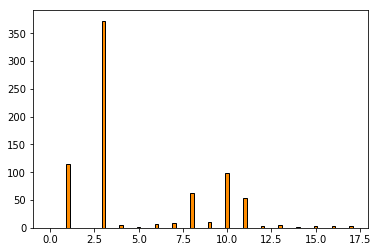

In [25]:
plt.bar(X_points , selector.scores_, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)', color='darkorange',
        edgecolor='black')

In [26]:
#STEP 3:Trying out a variety of classifiers and tuning them as well 

In [27]:
#Splitting data into training and testing set
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(X_new, y, test_size=0.30, random_state=42)


In [28]:
n_folds = 5
n_trees = 50

#level 0 classifiers
'''
clfs = [
    RandomForestClassifier(n_estimators = n_trees, criterion = 'gini', n_jobs = -1, warm_start = True, max_depth=5, min_samples_leaf=2,max_features='sqrt'),
    ExtraTreesClassifier(n_jobs=-1,n_estimators = n_trees, criterion = 'gini', max_depth=5, min_samples_leaf=3),
    GradientBoostingClassifier(n_estimators = n_trees, max_depth = 5, min_samples_leaf= 3),
    AdaBoostClassifier(n_estimators = int(n_trees/2), learning_rate = 0.95),
    xgb.XGBClassifier(),
    SVC(),
    sklearn.tree.DecisionTreeClassifier()
]'''
from sklearn.naive_bayes import GaussianNB
clfs = [
    RandomForestClassifier(n_estimators = n_trees, criterion = 'gini'),
    ExtraTreesClassifier(n_estimators = n_trees, criterion = 'gini'),
    GradientBoostingClassifier(n_estimators = n_trees),
    AdaBoostClassifier(n_estimators = int(n_trees/2)),
    xgb.XGBClassifier(),
    #SVC(),
    #sklearn.tree.DecisionTreeClassifier(),
    #sklearn.linear_model.Perceptron(tol=1e-3, random_state=0),
    #GaussianNB(),
    #sklearn.linear_model.LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial'),
    #sklearn.neighbors.KNeighborsClassifier(n_neighbors=3)
    
]

In [29]:
#first training and testing on the train.csv data only
 
def run(features_train, labels_train, features_test, clfs, n_folds = 5, labels_test = None, submission = False):
    import numpy as np
    # Ready for cross validation
    skfold = StratifiedKFold(n_splits=n_folds)
    skf = list(skfold.split(features_train, labels_train))
   
    # Pre-allocate the stacked dataset
    blend_train = np.zeros((features_train.shape[0], len(clfs))) # Number of training data x Number of classifiers
    blend_test = np.zeros((features_test.shape[0], len(clfs))) # Number of testing data x Number of classifiers
    
    if(submission == True):
        print("\nThis run is on entire training dataset and we will create a submission file in this run. :)")

    print ('\nfeatures_train.shape = %s' % (str(features_train.shape)))
    print ('features_test.shape = %s' % (str(features_test.shape)))
    print ('blend_train.shape = %s' % (str(blend_train.shape)))
    print ('blend_test.shape = %s' % (str(blend_test.shape)))

    # For each classifier, we train the number of fold times (=n_folds)
    for j, clf in enumerate(clfs):
        print ("\n#####################################################")
        print ('\nTraining classifier [%s]' % (str(j)))
        blend_test_j = np.zeros((features_test.shape[0], len(skf)))
        for i, (train_index, cv_index) in enumerate(skf):
            print ('Fold [%s]' % (str(i)))
        
            # This is the training and validation set
            #print ("train_index",train_index)
            X_train = features_train[train_index]
            Y_train = np.array(labels_train)[train_index]
            X_cv = features_train[cv_index]
            Y_cv = np.array(labels_train)[cv_index]
        
            clf.fit(X_train, Y_train)
        
            # This output will be the basis for our blended classifier to train against,
            # which is also the output of our classifiers
            blend_train[cv_index, j] = clf.predict(X_cv)
            blend_test_j[:, i] = clf.predict(features_test)
        
        # Take the mean of the predictions of the cross validation set
        blend_test[:, j] = blend_test_j.mean(1)
        pred = blend_test[:, j]
        #print (pred[0:5])
        #print (labels_test[0:5])
        pred[(pred >= 0.5)] = 1
        pred[(pred < 0.5)] = 0
        #print (pred[0:5])
        if (submission == False):
            
            print ("accuracy_score : ",accuracy_score(labels_test,pred))
            print ('precision : ',precision_score(labels_test,pred))
            print ('recall : ',recall_score(labels_test,pred))
    
    
    
    

    print ('\nlen(labels_train) = %s' % (str(len(labels_train))))

    # Start blending!
    bclf = SVC( kernel = 'linear', C = 0.025)
    bclf.fit(blend_train, labels_train)

    # Predict now
    Y_test_predict = bclf.predict(blend_test)
    if (submission == False):
        
        print ("\naccuracy_score : ",accuracy_score(labels_test,Y_test_predict))
        print ('precision : ',precision_score(labels_test,Y_test_predict))
        print ('recall : ',recall_score(labels_test,Y_test_predict))
    
    if (submission == True):
        x =range(892,1310)
        #creating the submission file
        submission=pd.DataFrame({'PassengerId':x,'Survived':Y_test_predict})
        print (submission.head())
        submission.to_csv(path_or_buf='submission.csv',index=False)
        
    print ("===========================================================================================================================")
    
run(features_train, labels_train, features_test, clfs, n_folds, labels_test)

# now, we train our model on complete data from train.csv file and test on data from test.csv file before we make our submission
run(X_new, y, X_test, clfs, n_folds, submission = True)


features_train.shape = (623, 14)
features_test.shape = (268, 14)
blend_train.shape = (623, 5)
blend_test.shape = (268, 5)

#####################################################

Training classifier [0]
Fold [0]
Fold [1]
Fold [2]
Fold [3]
Fold [4]
accuracy_score :  0.7947761194029851
precision :  0.7978723404255319
recall :  0.6756756756756757

#####################################################

Training classifier [1]
Fold [0]
Fold [1]
Fold [2]
Fold [3]
Fold [4]
accuracy_score :  0.7985074626865671
precision :  0.8
recall :  0.6846846846846847

#####################################################

Training classifier [2]
Fold [0]
Fold [1]
Fold [2]
Fold [3]
Fold [4]
accuracy_score :  0.8208955223880597
precision :  0.8705882352941177
recall :  0.6666666666666666

#####################################################

Training classifier [3]
Fold [0]
Fold [1]
Fold [2]
Fold [3]
Fold [4]
accuracy_score :  0.8059701492537313
precision :  0.7920792079207921
recall :  0.7207207207207207
